In [2]:
import requests
from bs4 import BeautifulSoup
import json
import html
import pandas as pd
import re
from concurrent.futures import ThreadPoolExecutor, as_completed

HEADERS = {
    "User-Agent": "Mozilla/5.0",
    "Accept-Language": "en-US,en;q=0.9"
}

def get_imdb_top_250_links():
    url = "https://www.imdb.com/chart/top/"
    response = requests.get(url, headers=HEADERS)
    soup = BeautifulSoup(response.text, 'html.parser')
    scripts = soup.find_all('script', type='application/ld+json')

    movie_links = []
    for script in scripts:
        try:
            data = json.loads(script.string)
            if isinstance(data, dict) and data.get("@type") == "ItemList":
                for i, item in enumerate(data.get("itemListElement", []), start=1):
                    movie_url = item.get("item", {}).get("url", "")
                    if movie_url:
                        full_url = f"https://www.imdb.com{movie_url}" if movie_url.startswith("/") else movie_url
                        movie_links.append((i, full_url))
        except json.JSONDecodeError:
            continue
    return movie_links

def parse_movie_page(ranked_url):
    rank, url = ranked_url
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')
        script = soup.find("script", type="application/ld+json")
        if not script or not script.string:
            raise ValueError("Missing ld+json script")

        movie_data = json.loads(script.string)

        title = html.unescape(movie_data.get("name", ""))
        year = int(movie_data.get("datePublished", "0")[:4])
        rating = float(movie_data.get("aggregateRating", {}).get("ratingValue", 0))
        votes = int(movie_data.get("aggregateRating", {}).get("ratingCount", 0))
        genres = movie_data.get("genre", [])
        genres = genres if isinstance(genres, list) else [genres]
        directors = [d["name"] for d in movie_data.get("director", [])]
        cast = [a["name"] for a in movie_data.get("actor", [])][:3]

        runtime_str = movie_data.get("duration", "")
        runtime_min = None
        if "H" in runtime_str and "M" in runtime_str:
            h, m = re.search(r'PT(\d+)H(\d+)M', runtime_str).groups()
            runtime_min = int(h) * 60 + int(m)
        elif "M" in runtime_str:
            m = re.search(r'PT(\d+)M', runtime_str).group(1)
            runtime_min = int(m)

        gross = '0'
        gross_li = soup.find('li', attrs={'data-testid': 'title-boxoffice-cumulativeworldwidegross'})
        if gross_li:
            gross_text = gross_li.find('span', class_='ipc-metadata-list-item__list-content-item')
            if gross_text:
                gross = gross_text.text.strip().replace('$', '').replace(',', '')

        return {
            'Standing': rank,
            'Title': title,
            'Release Year': year,
            'IMDb Rating': rating,
            'Number of Votes': votes,
            'Genre(s)': genres,
            'Director(s)': directors,
            'Top 3 Cast Members': cast,
            'Runtime (minutes)': runtime_min,
            'Worldwide Gross (USD)': pd.to_numeric(gross, errors='coerce')
        }
    except Exception as e:
        return None

def scrape_all_movies():
    movie_links = get_imdb_top_250_links()
    results = []
    print(f"Scraping {len(movie_links)} movies...")
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(parse_movie_page, link) for link in movie_links]
        for future in as_completed(futures):
            result = future.result()
            if result:
                results.append(result)

    df = pd.DataFrame(results)
    df = df.sort_values("Standing").reset_index(drop=True)
    return df

def transform_to_relational(df):
    base_df = df.drop(columns=['Genre(s)', 'Director(s)', 'Top 3 Cast Members'])
    genre_df = df[['Title', 'Genre(s)']].explode('Genre(s)').dropna()
    director_df = df[['Title', 'Director(s)']].explode('Director(s)').dropna()
    actor_df = df[['Title', 'Top 3 Cast Members']].explode('Top 3 Cast Members').dropna()

    return base_df, genre_df, director_df, actor_df

if __name__ == "__main__":
    full_df = scrape_all_movies()
    full_df.to_csv("IMDb_Top_250_Full_Details.csv", index=False)
    print("Full movie data saved to 'IMDb_Top_250_Full_Details.csv'")

    base_df, genre_df, director_df, actor_df = transform_to_relational(full_df)
    base_df.to_csv("IMDb_Top_250_Movies.csv", index=False)
    genre_df.to_csv("IMDb_Top_250_Genres.csv", index=False)
    director_df.to_csv("IMDb_Top_250_Directors.csv", index=False)
    actor_df.to_csv("IMDb_Top_250_Actors.csv", index=False)
    print("Relational dataframes saved.")

Scraping 250 movies...
Full movie data saved to 'IMDb_Top_250_Full_Details.csv'
Relational dataframes saved.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def graphs():
    df = pd.read_csv("IMDb_Top_250_Full_Details.csv")
    df = df[df["Release Year"] >= 1800]
    df_after_2010 = df[df["Release Year"] >= 2010]
    merged_df = pd.merge(df, genre_df, on="Title", how="inner")

    # Top 20 IMDB
    top20 = df.sort_values("IMDb Rating", ascending=False).head(20)
    plt.figure(figsize=(10, 7))
    sns.barplot(data=top20, y="Title", x="IMDb Rating", color='slateblue', edgecolor="black")
    plt.title("Top 20 Movies by IMDb Rating")
    plt.xlabel("IMDb Rating")
    plt.ylabel("Movie Title")
    plt.xlim(7, 9.5)
    plt.grid(True, axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Movie Count per Decade
    plt.figure(figsize=(10, 5))
    sns.histplot(df["Release Year"].dropna(), bins=range(1920, 2031, 10), color="darkblue", edgecolor="black", kde=True)
    plt.title("Movie Count per Decade")
    plt.xlabel("Decade")
    plt.ylabel("Number of Movies")
    plt.grid(True, axis='y', linestyle='--')
    plt.xticks(ticks=range(1920, 2031, 10))
    plt.tight_layout()
    plt.show()

    # Top 20 after 2010
    top20_after_2010 = df_after_2010.sort_values("IMDb Rating", ascending=False).head(20)
    plt.figure(figsize=(10, 7))
    sns.barplot(data=top20_after_2010, y="Title", x="IMDb Rating", color='slateblue', edgecolor="black")
    plt.title("Top 20 Movies by IMDb Rating (after 2010)")
    plt.xlabel("IMDb Rating")
    plt.ylabel("Movie Title")
    plt.xlim(7, 9.5)
    plt.grid(True, axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

    # IMDb Rating Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(df["IMDb Rating"], bins=10, color="darkblue", edgecolor="black", kde=True)
    plt.title("IMDb Rating Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Number of Movies")
    plt.grid(True, axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Runtime Distribution: All vs After 2010
    plt.figure(figsize=(10, 5))
    sns.histplot(df["Runtime (minutes)"].dropna(), bins=20, color="darkblue", edgecolor="black", kde=True, alpha=0.6, label="All Movies")
    sns.histplot(df_after_2010["Runtime (minutes)"].dropna(), bins=20, color="crimson", edgecolor="black", kde=True, alpha=0.6, label="After 2010")
    plt.title("Movie Runtime Distribution: All vs After 2010")
    plt.xlabel("Runtime (minutes)")
    plt.ylabel("Number of Movies")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Runtime by Genre
    top_10_genres = merged_df['Genre(s)_y'].value_counts().head(10).index
    top_10_genres_df = merged_df[merged_df['Genre(s)_y'].isin(top_10_genres)]
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=top_10_genres_df, x="Genre(s)_y", y="Runtime (minutes)", color='slateblue')
    plt.title("Runtime Distribution by Genre")
    plt.xlabel("Genre")
    plt.ylabel("Runtime (minutes)")
    plt.grid(True, axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Top 10 Directors
    top_directors = director_df['Director(s)'].value_counts().head(10)
    plt.figure(figsize=(10, 5))
    bars = plt.bar(top_directors.index, top_directors.values, color="slateblue", edgecolor='black')
    for bar, val in zip(bars, top_directors.values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{val:.1f}", ha='center', va='center', fontsize=10)
    plt.title("Top 10 Most Frequent Directors")
    plt.ylabel("Number of Movies")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Top 10 Actors
    top_actors = actor_df['Top 3 Cast Members'].value_counts().head(10)
    plt.figure(figsize=(10, 5))
    bars = plt.bar(top_actors.index, top_actors.values, color="slateblue", edgecolor='black')
    for bar, val in zip(bars, top_actors.values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{val:.1f}", ha='center', va='center', fontsize=10)
    plt.title("Top 10 Most Frequent Actors")
    plt.ylabel("Number of Movies")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Top 10 Genres
    top_genres = genre_df['Genre(s)'].value_counts().head(10)
    colors = plt.cm.tab10.colors
    plt.figure(figsize=(10, 5))
    bars = plt.bar(top_genres.index, top_genres.values, color=colors, edgecolor='black')
    for bar, val in zip(bars, top_genres.values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f"{val:.1f}", ha='center', va='center', fontsize=10)
    plt.title("Top 10 Most Frequent Genres")
    plt.ylabel("Number of Movies")
    plt.grid(True, axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Genre Donut Chart (All vs After 2010)
    genre_counts_all = merged_df["Genre(s)_y"].value_counts()
    genre_counts_2010 = merged_df[merged_df["Release Year"] > 2010]["Genre(s)_y"].value_counts()
    top_10 = genre_counts_all.head(10).index.tolist()
    outer = pd.concat([genre_counts_all[top_10], pd.Series({"Other": genre_counts_all[~genre_counts_all.index.isin(top_10)].sum()})])
    inner = pd.concat([genre_counts_2010[top_10], pd.Series({"Other": genre_counts_2010[~genre_counts_2010.index.isin(top_10)].sum()})])
    colors = list(plt.cm.tab10.colors[:10]) + ['gray']
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.pie(outer, labels=outer.index, radius=1, colors=colors, startangle=90, autopct='%1.1f%%', pctdistance=0.875, wedgeprops=dict(width=0.25, edgecolor='black'), textprops=dict(fontsize=10))
    ax.pie(inner, radius=0.70, colors=colors, startangle=90, autopct='%1.1f%%', pctdistance=0.80, wedgeprops=dict(width=0.25, edgecolor='black'), textprops=dict(fontsize=10))
    ax.set(aspect="equal", title="Genre Popularity (Top 10 + Other)\nOuter: All Years | Inner: After 2010")
    plt.tight_layout()
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(10, 6))
    numerics = df[["IMDb Rating", "Number of Votes", "Runtime (minutes)", "Worldwide Gross (USD)"]]
    sns.heatmap(numerics.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Between Numeric Indicators")
    plt.tight_layout()
    plt.show()


In [4]:
full_df[:20]

,Standing,Title,Release Year,IMDb Rating,Number of Votes,Genre(s),Director(s),Top 3 Cast Members,Runtime (minutes),Worldwide Gross (USD)
0,1,The Shawshank Redemption,1994,9.3,3127364,[Drama],[],[],142.0,29334033
1,2,The Godfather,1972,9.2,2181939,"[Crime, Drama]",[],[],175.0,250926102
2,3,The Dark Knight,2008,9.1,3102907,"[Action, Crime, Drama]",[],[],152.0,1009242873
3,4,The Godfather Part II,1974,9.0,1466909,"[Crime, Drama]",[],[],202.0,48203923
4,5,12 Angry Men,1957,9.0,960641,"[Crime, Drama]",[],[],96.0,2945
5,6,The Lord of the Rings: The Return of the King,2003,9.0,2124359,"[Adventure, Drama, Fantasy]",[],[],201.0,1139431705
6,7,Schindler's List,1994,9.0,1560094,"[Biography, Drama, History]",[],[],195.0,322161245
7,8,The Lord of the Rings: The Fellowship of the Ring,2001,8.9,2160715,"[Adventure, Drama, Fantasy]",[],[],178.0,889476171
8,9,Pulp Fiction,1994,8.8,2389169,"[Crime, Drama]",[],[],154.0,213928762
9,10,"Il buono, il brutto, il cattivo",1967,8.8,877261,"[Adventure, Drama, Western]",[],[],178.0,25273906


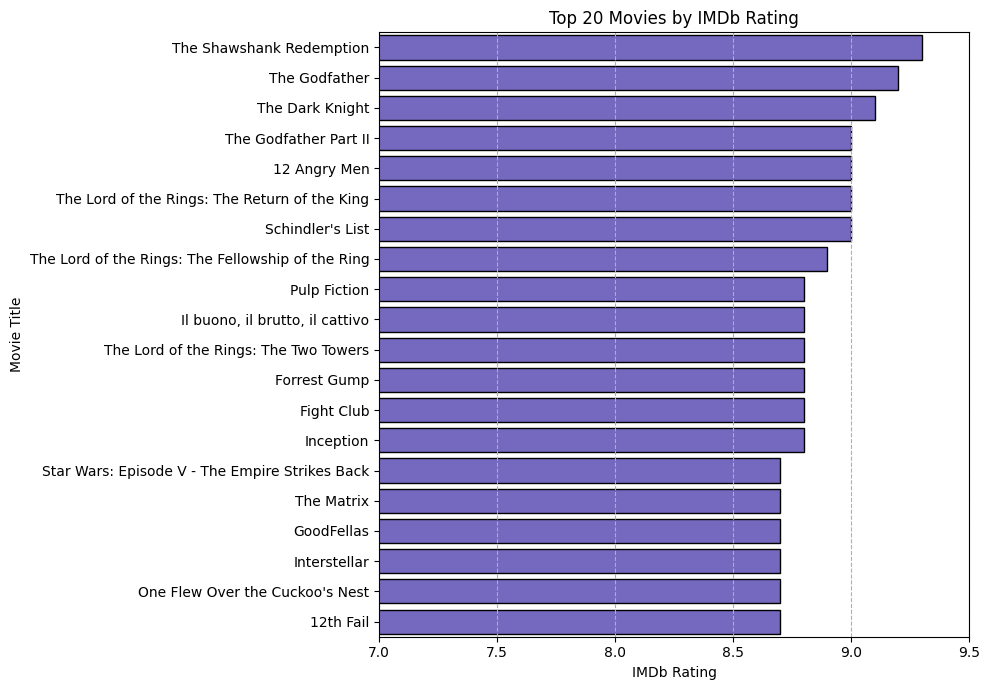

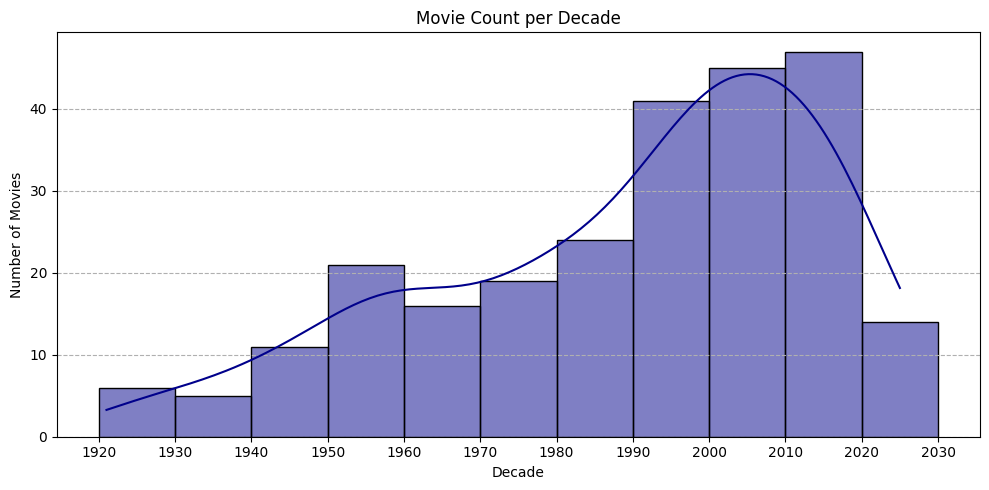

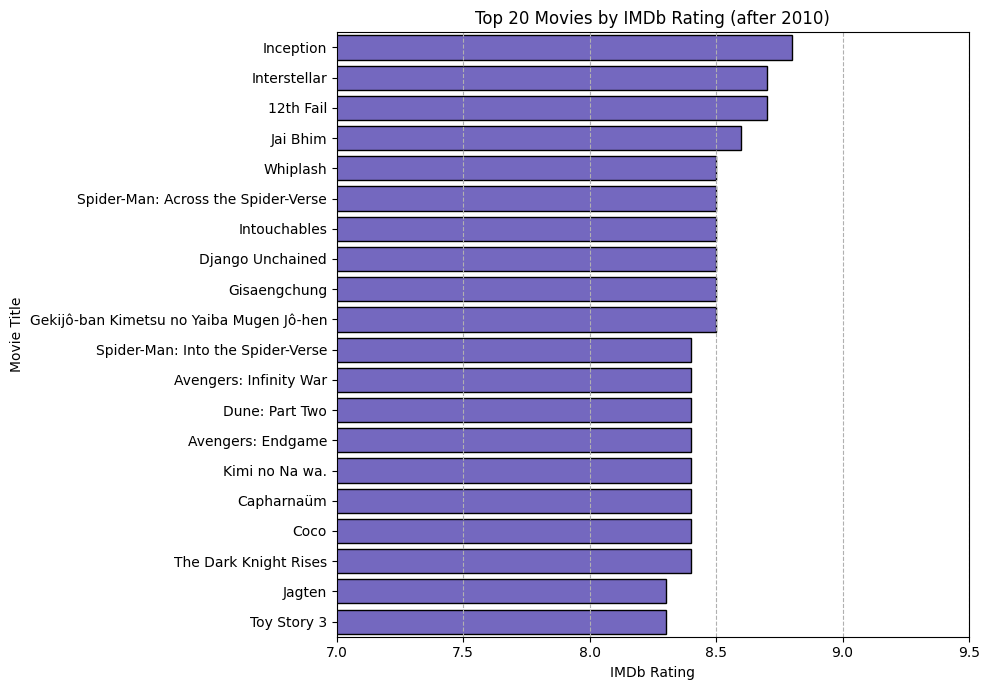

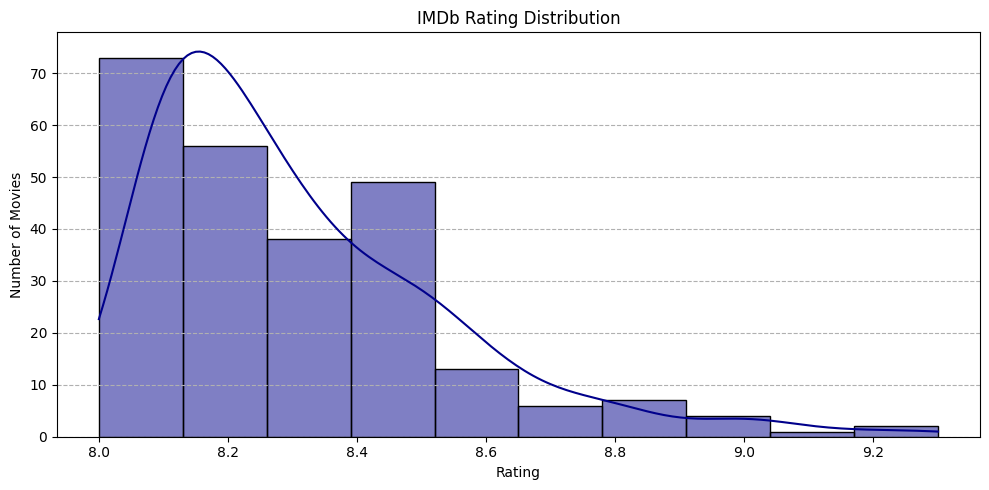

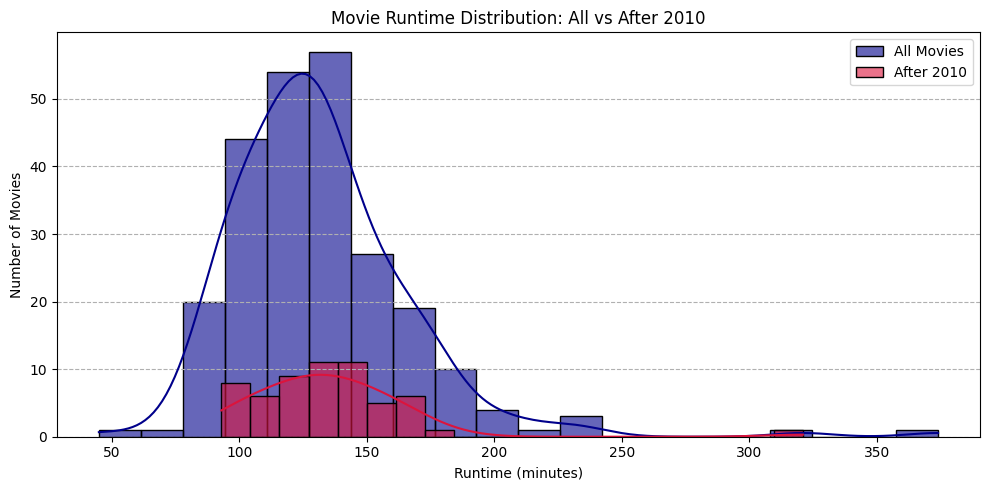

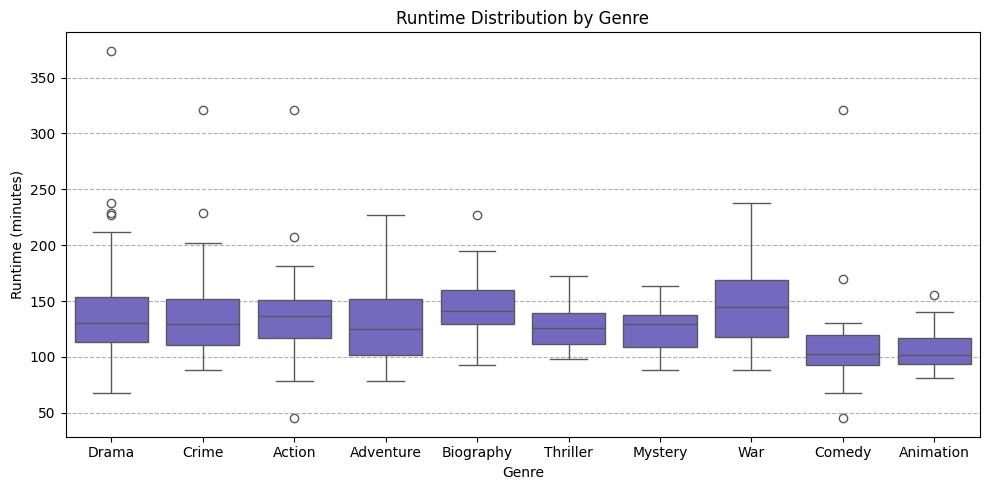

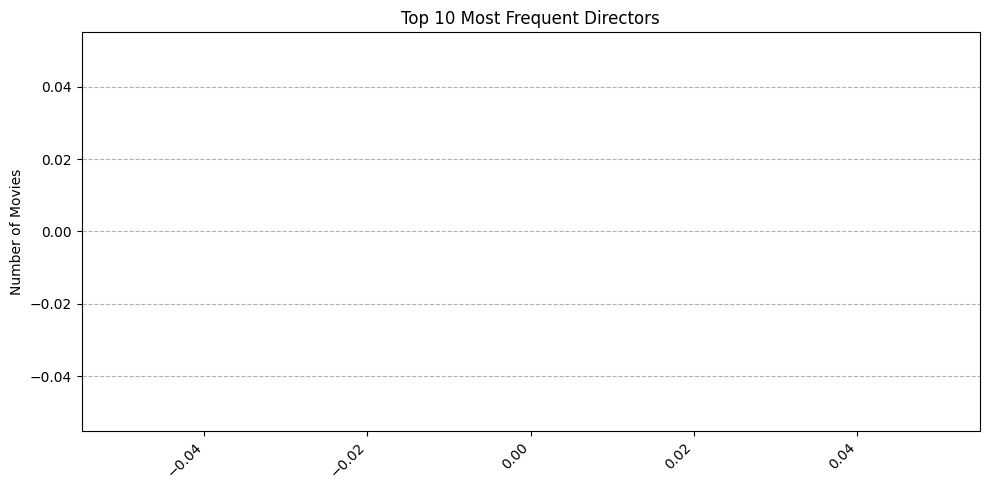

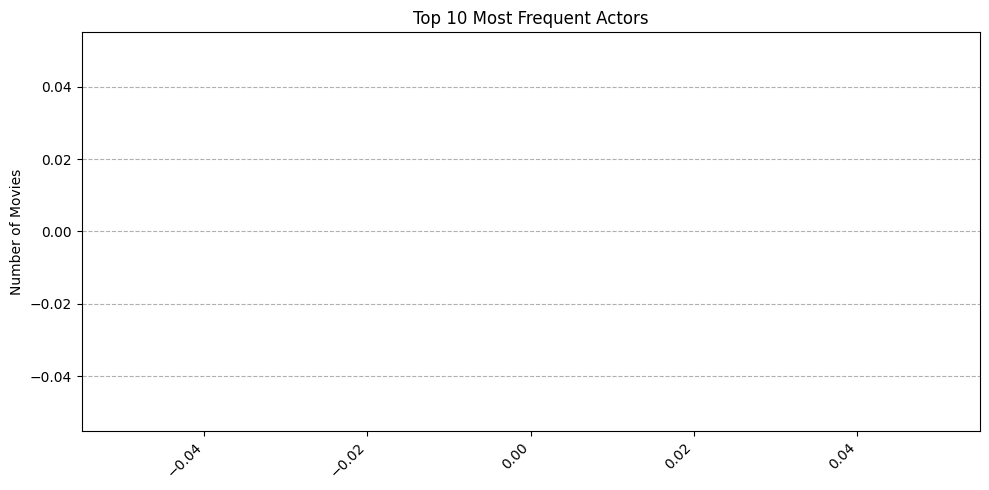

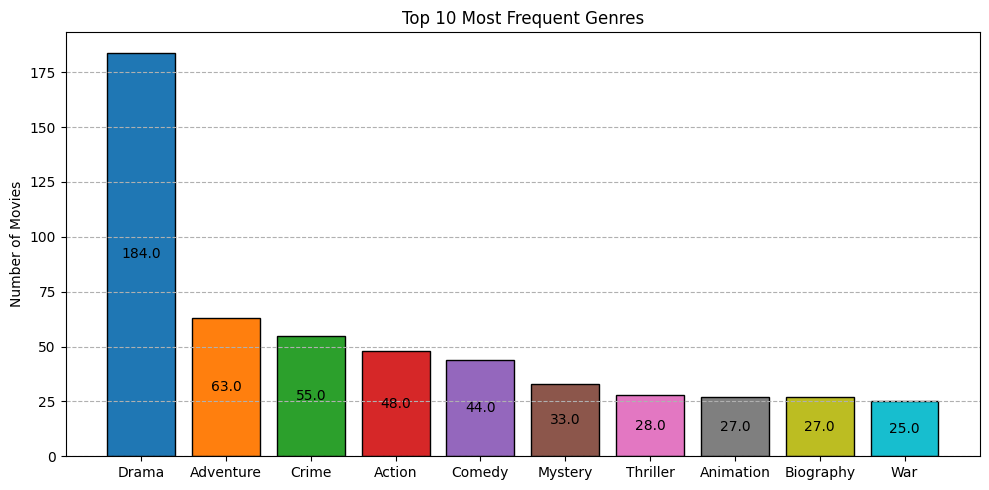

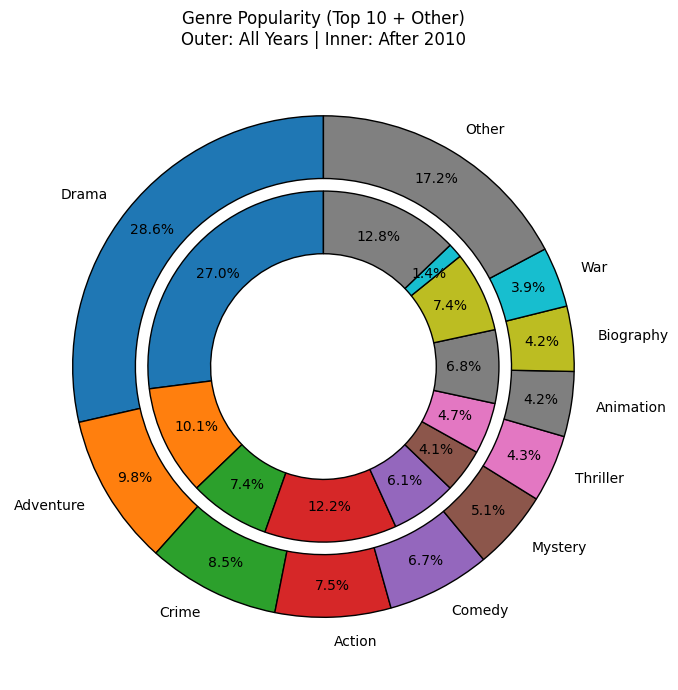

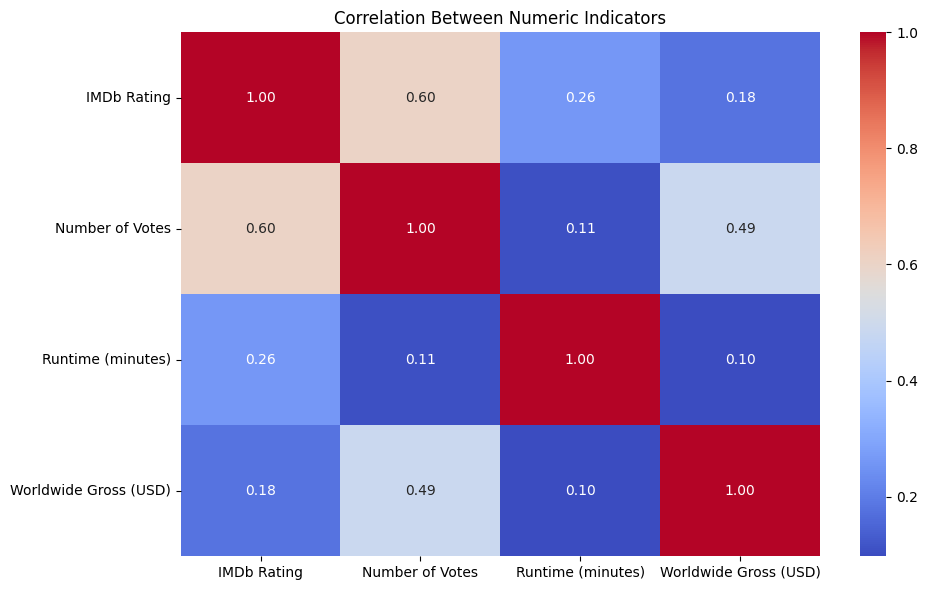

In [5]:
graphs()